# To do:
* Quick specification: regression with and without wins
* add foul rate to specification
* aggregate at city level for race stuff


Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

Get Twitter data for comparison

# Drivers of Reddit NBA sentiment
This notebook investigates what drives the sentiment of NBA players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nfl-sentiment.ipynb`.

For the most fun, I would skip to **Exploration of sentiment values**

In [1]:
import json
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\map22\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\map22\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd
from named_entities import NICKNAMES_OLDTIMERS, TEAMS, NON_PLAYERS, UPPER_ENTITIES

In [3]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [4]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_race.tsv', sep='\t')
coaches = set([name for coach in list(coaches_race_df.iloc[:,0]) for name in coach.split(' ')] )

FileNotFoundError: File b'd:/data/sentiment_sports/covariates/nba_coach_performance.tsv' does not exist

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [5]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'loss', 'losses', 'playing', 'vicious', 'jj']
bad_words = ['foul', 'ridiculous', 'motherfucking', 'mediocre', 'soft', 'slow', 'delusional']
great_words = ['goat', 'nasty', 'prime', 'mvp']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [6]:
covariates_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_player_covariates.tsv', sep='\t')
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,SG,23,68,1055,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.096,NaN,-0.3,-2.2,-2.5,-0.1,OKC,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,C,23,80,2389,16.5,0.589,0.002,0.392,13.0,15.4,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.5,0.130,NaN,-0.7,1.2,0.6,1.5,OKC,4.7,8.2,0.571,0.0,0.0,0.000,4.7,8.2,0.572,0.571,2.0,3.2,0.611,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


In [7]:
UNIQUE_NAMES = set(covariates_df.Player.unique())
UNIQUE_NAMES = UNIQUE_NAMES.union(set(coaches_race_df.iloc[:,0]))

In [8]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union(NICKNAMES_OLDTIMERS)
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
NAMED_ENTITIES = NAMED_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)
NAMED_ENTITIES = NAMED_ENTITIES.union(NON_PLAYERS)
NAMED_ENTITIES = NAMED_ENTITIES.union(coaches)

### Load covariates

In [9]:
text_col = 'sentences'
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=NON_PLAYERS, UPPER_NAMES = UPPER_ENTITIES, TEXT_COL = text_col)[1]

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv.gz'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805]]
nba2017_df = pd.concat(year_dfs)
nba2017_df.shape

In [16]:
%%time
nba2017_df = ss.fuzzy_match_players(nba2017_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 4min 5s


In [25]:
nba2017_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
oct_df = create_month_df(file_stub.format(201610))
nov_df = create_month_df(file_stub.format(201611))
dec_df = create_month_df(file_stub.format(201612))
jan_df = create_month_df(file_stub.format(201701))
feb_df = create_month_df(file_stub.format(201702) + '.gz')
mar_df = create_month_df(file_stub.format(201703) + '.gz')
apr_df = create_month_df(file_stub.format(201704) + '.gz')
may_df = create_month_df(file_stub.format(201705) + '.gz')

In [27]:
nba2016_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2016_df.shape
# previously 888k

(897510, 15)

In [28]:
nba2016_df = ss.fuzzy_match_players(nba2016_df, UNIQUE_NAMES)

Fuzzy matching player names


In [29]:
nba2016_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605]]
nba2015_df = pd.concat(year_dfs)
nba2015_df.shape

In [31]:
nba2015_df = ss.fuzzy_match_players(nba2015_df, UNIQUE_NAMES)

Fuzzy matching player names


In [32]:
nba2015_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2014 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201411, 201412, 201501, 201502, 201503, 201504, 201505]]
nba2014_df = pd.concat(year_dfs)
nba2014_df.shape

In [34]:
nba2014_df = ss.fuzzy_match_players(nba2014_df, UNIQUE_NAMES)

Fuzzy matching player names


In [35]:
nba2014_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2014.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2013 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201311, 201312, 201401, 201402, 201404, 201405]]
nba2013_df = pd.concat(year_dfs)
nba2013_df.shape

In [37]:
nba2013_df = ss.fuzzy_match_players(nba2013_df, UNIQUE_NAMES)

Fuzzy matching player names


In [38]:
nba2013_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2013.tsv', sep='\t',
               index=False, encoding = 'utf-8')

### Load comment sentiment data

In [10]:
nba2013_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2013.tsv',sep='\t', encoding = 'utf-8')
nba2013_df['named_entities'] = nba2013_df['named_entities'].apply(literal_eval)
nba2014_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2014.tsv',sep='\t', encoding = 'utf-8')
nba2014_df['named_entities'] = nba2014_df['named_entities'].apply(literal_eval)
nba2015_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv',sep='\t', encoding = 'utf-8')
nba2015_df['named_entities'] = nba2015_df['named_entities'].apply(literal_eval)
nba2016_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nba2017_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv',sep='\t', encoding = 'utf-8').drop(columns='Unnamed: 0')
nba2017_df['named_entities'] = nba2017_df['named_entities'].apply(literal_eval)

C:\Users\map22\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
nba2013_df['season'] = 2013
nba2014_df['season'] = 2014
nba2015_df['season'] = 2015
nba2016_df['season'] = 2016
nba2017_df['season'] = 2017

In [12]:
nba_df = pd.concat([nba2013_df, nba2014_df, nba2015_df, nba2016_df, nba2017_df])

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [13]:
nba_df.shape

(4480790, 20)

#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [14]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                           'sam sam', 'shaquille shaquille', 'blue', 'jamal curry', 'david westbrook', 'griffin baker', 'chris pau',
                           'jimmy tyler', 'london','jackson tatum', 'ball', 'early', 'phil', 'world', 'peace',
                            'wilt', 'wallace', 'leaf', 'billy', 'jalen', 'reggie', 'hakeem', 'kareem', 'zo']}
name_map.update({'giannis':'giannis antetokounmpo', 'kd':'kevin durant', 'kd kd': 'kevin durant',
                 'lbj':'lebron james', 'lma':'lamarcus aldridge', 
                 'shump': 'iman shumpert', 'blake': 'blake griffin',
                 'kat': 'karl-anthony towns', 'dwight': 'dwight howard',
                 'boogie':'demarcus cousins', 'demar': 'demar derozan',
                'klove':'kevin love', 'cj': 'cj mccollum', 'shabazz': 'shabazz muhammad',
                'ingram': 'brandon ingram', 'manu': 'manu ginobili', 'thon': 'thon maker',
                'simmons': 'ben simmons', 'ben': 'ben simmons', 'jj':'jj redick',
                'wade': 'dwyane wade', 'nance jr': 'larry nance', 'pau':'pau gasol',
                 'mbah moute': 'luc mbah a moute', 'luc': 'luc mbah a moute',
                'lin': 'jeremy lin', 'iggy':'andre iguodala', 'lue':'tyronn lue', 'tt':'tristan thompson',
                'hayward': 'gordon hayward', 'lonzo':'lonzo ball', 'mj':'michael jordan',
                 'mcbuckets':'doug mcdermott', 'cp3':'chris paul', 'steph':'stephen curry', 'curry':'stephen curry',
                'delly': 'matthew dellavedova'})

In [15]:
%%time
nba_df['fuzzy_name'] = nba_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 1min 28s


Remove players whose names have implicit sentiment

In [16]:
senti_players = ['jerian grant', 'jerami grant', 'marcus smart', 'justin holiday','jrue holiday', 'kevin love', 'derrick favors',
                'rakeem christmas', 'ty lawson', 'metta world peace']
nba_df = nba_df[nba_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [17]:
match_df = nba_df.query('fuzzy_name != "unclear"')
match_df.shape

(2554364, 20)

### User-level metrics

In [18]:
match_df['score'] = match_df['score'].astype(float)

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
user_df = match_df.fillna({'score':0}).groupby('user').agg({'score':['sum', 'count', 'mean']})
user_df.columns = ['user_total_score', 'user_total_comments', 'user_mean_score']

## Calculating sentiment towards each player
#### First calculate the average sentiment for each player from each user
A naive approach might simply average the sentiment across all comments; this approach would be biased towards the sentiment of the most common posters. Instead, I calculated the sentiment towards each player by each user, then in a second step averaged the sentiment across users.

In [20]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'flair', 'season'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'flair', 'season', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df['fuzzy_name'] = user_player_sentiment_df['fuzzy_name'].str.replace('\.', '')
user_player_sentiment_df.head(2)

,fuzzy_name,user,flair,season,compound_mean,compound_std,comment_count
0,aaron brooks,2RealNeal,Pacers,2016,0.0000,0.0,2
1,aaron brooks,53toaster,Bulls,2014,-0.6696,0.0,2


#### Match user flairs to teams

In [21]:
flair_dict = {'Celtics':'BOS', 'Cavaliers':'CLE', 'Lakers':'LAL', 'Raptors':'TOR', 'Warriors':'GSW',
              'Spurs':'SAS', '76ers':'PHI', 'Knicks':'NYK', 'Rockets':'HOU', 'Bulls':'CHI', 'Thunder':'OKC',
              'Trail Blazers':'POR', 'Timberwolves':'MIN', 'Heat':'MIA', 'Wizards':'WAS', 'Jazz':'UTA',
              'Bucks':'MIL', 'Mavericks':'DAL', 'Pistons':'DET', 'Kings':'SAC',
              'Suns':'PHO', 'Clippers':'LAC', 'Hawks':'ATL',
              'Hornets':'CHO', 'Nuggets':'DEN', 'Pacers':'IND',
              'Pelicans':'NOP', 'Nets':'BRK', 'Magic':'ORL', 'Grizzlies':'MEM'}
def get_flair(flair_string, flair_dict, flair_regex):
    ''' Match flairs that are team name, or have team abbreviation within brackets'''
    if flair_string in flair_dict:
        return flair_dict[flair_string]
    elif re.match(flair_regex, flair_string):
        return re.search(flair_regex, flair_string).groups(1)[0]
    return 'no_team'
flair_regex = '^\[(\w{3})\]'
user_player_sentiment_df['user_Tm'] = user_player_sentiment_df['flair'].apply(lambda row: get_flair(row, flair_dict, flair_regex))

In [22]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

In [24]:
user_player_regression_df = (user_player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'season'], how = 'left')
                         .merge(user_df, on='user', how='left')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24']))
user_player_regression_df['team_match'] = user_player_regression_df['Tm'] == user_player_regression_df['user_Tm']
user_player_regression_df = (user_player_regression_df.drop(columns = ['metro_percent_white', 'metro_percent_black', 'clinton_vote_lead', 'total_population'])
                                    .merge(vote_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left')
                                    .merge(city_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left'))
user_player_regression_df['youth'] = (user_player_regression_df['Age'].mean() - user_player_regression_df['Age']).clip(0)
user_player_regression_df['oldness'] = (user_player_regression_df['Age'] - user_player_regression_df['Age'].mean()).clip(0)
user_player_regression_df['rookie'] = user_player_regression_df['experience'] <=4
user_player_regression_df['ThreePP'] =user_player_regression_df['ThreePP'].fillna(user_player_regression_df['ThreePP'].mean())
user_player_regression_df['white_black_diff'] = user_player_regression_df['metro_percent_white'] - user_player_regression_df['metro_percent_black']
user_player_regression_df['height_dummies'] = pd.cut(user_player_regression_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])
user_player_regression_df.to_csv('C:/Users/map22/Google Drive/sentiment_nba/nba_user_player_sentiment.tsv', sep='\t', index=False)

In [25]:
user_player_regression_df.to_csv('C:/Users/map22/Google Drive/sentiment_nba/nba_user_player_sentiment.tsv', sep='\t', index=False)

#### Then calculate the average sentiment to players across all users

In [23]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'season'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'season', 'compound_mean_mean', 'compound_mean_std', 'user_count']

## Exploration of sentiment values
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

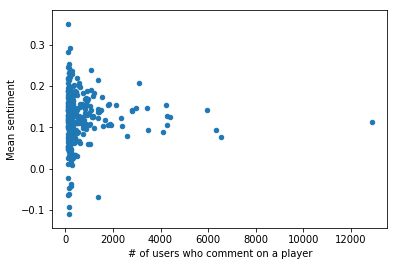

In [24]:
player_sentiment_df.query('user_count> 100 and season ==2017').plot('user_count', 'compound_mean_mean', kind='scatter')
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [25]:
player_sentiment_df.query('season ==2017').sort_values('user_count', ascending=False).head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
2375,lebron james,2017,0.113354,0.342369,12878
2186,kevin durant,2017,0.076652,0.380443,6555
1592,james harden,2017,0.093511,0.369233,6343
3483,stephen curry,2017,0.142916,0.367887,5969
2315,kyrie irving,2017,0.126036,0.383751,4384


#### Players with lowest sentiment
Sterling Brown's sentiment probably reflects a combination of sentiment towards police and himself. Other players on this list like Zaza Pachulia and Salah Mejri are well known disliked players.

In [75]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
2687,mike dunleavy,2016,-0.110085,0.471321,236
3501,steve blake,2015,-0.103281,0.428804,216
2136,kelly olynyk,2016,-0.074903,0.468779,486
1254,fred hoiberg,2016,-0.070902,0.453887,221
3939,zaza pachulia,2017,-0.069070,0.437777,1376


In [76]:
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "sterling brown"')

#### Players with highest sentiment
This list seems biased towards players with relatively low comment counts

In [92]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(8)

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1346,gordon hayward,2014,0.244566,0.393865,300
2112,karl-anthony towns,2014,0.246114,0.369094,217
369,brad stevens,2015,0.248160,0.410713,309
2499,marc gasol,2014,0.250123,0.372446,240
2113,karl-anthony towns,2015,0.257979,0.360460,1113
398,brandon ingram,2015,0.269397,0.334156,228
704,coty clarke,2017,0.292881,0.409342,207
368,brad stevens,2014,0.308052,0.374051,218


#### Players with highest std of sentiment
Again, this appears biased towards players with relatively low comment counts.

In [78]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
2201,kevin mchale,2017,0.038036,0.485842,213
2597,matt barnes,2014,-0.016909,0.483414,297
2599,matt barnes,2016,0.008327,0.483199,246
2988,paul pierce,2017,0.033788,0.479018,419
2598,matt barnes,2015,0.010249,0.477263,272


## Explore demographics relationship with sentiment
#### Join player sentiment to performance and demographics
To see how sentiment is related to demographics, we can join the sentiment table above with the player demographics dataframe `covariates_df`.

I include only players with at least 50 comments to remove noise

In [26]:
join_df = (player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'season'], how = 'left')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24'])).query('user_count > 10')

#### Sentiment versus performance
Surprisingly, there seems to be relatively little correlation between player performance and sentiment towards the player

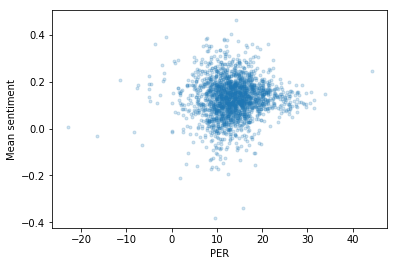

In [80]:
plt.plot(join_df['PER'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.2);
plt.xlabel('PER')
plt.ylabel('Mean sentiment');

#### Sentiment and race
On average, sentiment towards black players is slightly lower than towards white players

In [81]:
join_df.groupby('Race').mean()

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,2015.333333,0.114960,0.403835,694.666667,2012.166667,2018.000000,76.666667,201.666667,301.333333,26.166667,46.333333,1173.500000,13.450000,0.517167,0.346000,0.420333,2.066667,9.750000,5.950000,22.366667,1.400000,2.483333,17.416667,23.200000,1.116667,0.950000,2.066667,0.058667,-1.783333,-1.683333,-3.450000,0.433333,3.650000,8.716667,0.387500,0.966667,2.650000,0.340000,2.716667,6.083333,0.428333,0.438667,3.283333,3.766667,0.819333,0.333333,1.916667,2.233333,3.483333,0.683333,0.416667,2.100000,2.166667,11.516667,2016.333333,39.333333,1.143310e+07,62.033333,16.250000,0.377250,7.760301e+06,49.217093,4.166667
B,2015.074196,0.131596,0.416750,278.864741,2010.782666,2017.547603,78.502955,218.274458,245.432042,26.551543,57.021668,1362.076822,13.454169,0.526672,0.298304,0.270037,4.755417,14.515430,9.643861,13.454629,1.638017,1.623375,12.977895,19.201576,1.474590,1.378661,2.853053,0.080726,-1.021274,-0.301904,-1.322784,0.726527,3.439396,7.665726,0.442907,0.791202,2.262705,0.304379,2.648654,5.403874,0.481064,0.493170,1.579317,2.083454,0.739994,0.878792,2.844452,3.719961,2.020683,0.719173,0.421536,1.249639,1.795141,9.245305,2016.074196,41.114905,5.438207e+06,67.267695,15.607551,0.376970,5.765559e+06,43.822885,5.291530
L,2014.181818,0.046014,0.434287,97.363636,2008.000000,2016.363636,80.000000,236.363636,354.636364,30.636364,40.000000,818.636364,10.836364,0.481182,0.293636,0.259091,5.900000,14.963636,10.463636,15.818182,1.600000,1.500000,15.609091,15.954545,0.772727,0.754545,1.536364,0.065727,-2.036364,0.036364,-2.000000,0.281818,2.209091,5.236364,0.401818,0.554545,1.736364,0.212889,1.654545,3.518182,0.431000,0.447273,0.727273,1.018182,0.646182,0.881818,2.454545,3.318182,1.972727,0.554545,0.318182,0.981818,1.845455,5.672727,2015.181818,46.181818,5.703959e+06,62.590909,17.000000,0.372373,5.771912e+06,46.552692,7.181818
M,2014.910256,0.115210,0.420393,636.192308,2010.307692,2017.358974,77.448718,208.282051,246.000000,27.115385,56.307692,1475.141026,14.647436,0.523513,0.299808,0.224654,4.101282,13.488462,8.834615,20.152564,1.811538,1.038462,13.746154,20.265385,2.183333,1.515385,3.694872,0.094064,0.057692,-0.321795,-0.262821,1.212821,4.106410,9.012821,0.438808,1.105128,2.893590,0.328987,2.998718,6.125641,0.462897,0.494308,1.670513,2.175641,0.737720,0.837179,2.871795,3.711538,3.137179,0.819231,0.314103,1.508974,1.856410,10.982051,2015.910256,44.641026,7.528010e+06,61.698718,11.994872,0.408442,7.982262e+06,47.407005,5.602564
R,2016.250000,0.046093,0.450531,105.750000,2016.500000,2018.000000,83.250000,241.250000,323.500000,28.500000,54.000000,638.250000,13.625000,0.592250,0.123250,0.444750,9.650000,22.100000,15.725000,5.150000,1.425000,5.875000,18.650000,13.625000,0.575000,1.125000,1.725000,0.119000,-3.575000,3.275000,-0.300000,0.300000,1.250000,2.375000,0.562000,0.125000,0.350000,0.171750,1.150000,2.025000,0.565750,0.582250,0.600000,1.025000,0.585750,1.050000,2.275000,3.325000,0.400000,0.325000,0.800000,0.625000,1.650000,3.275000,2017.250000,38.500000,6.400053e+06,71.600000,13.475000,0.292175,1.009611e+06,31.299630,0.750000
W,2015.040000,0.122122,0.415127,182.069474,2011.258947,2017.463158,81.223158,231.867368,244.117895,27.143158,56.976842,1206.328421,13.505684,0.542290,0.286214,0.281353,6.097895,17.126737,11.610737,11.634105,1.334316,1.862947,14.032558,17.647789,1.454737,1.268842,2.723789,0.092152,-1.169684,-0.102526,-1.268000,0.553895,2.864842,6.180632,0.460169,0.644842,1.751368,0.300479,2.221684,4.427579,0.492185,0.511518,1.237053,1.636421,0.743082,1.028421,2.958316,3.984632,1.539789,0.513895,0.43347

#### Sentiment and age / experience
Generally, sentiment seems to be higher for young and old players (where there is selection bias in that skilled / popular players have longer careers).

(0, 20)

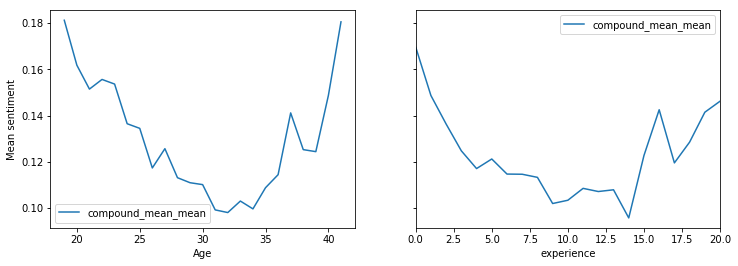

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')
ax2.set_xlim([0, 20])

#### Height

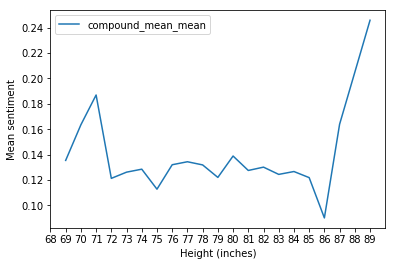

In [83]:
join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [84]:
join_df.groupby('Pos_y').mean().reset_index()

,Pos_y,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,C,2015.095012,0.129302,0.413335,261.648456,2010.745843,2017.463183,83.137767,252.833729,249.952494,26.916865,56.204276,1203.061758,16.010689,0.558155,0.062455,0.382486,10.209976,21.909264,16.078622,8.713539,1.314489,3.650356,14.819286,17.967696,1.770071,1.664608,3.432304,0.120166,-1.678147,1.330404,-0.345843,0.871021,3.185036,6.134679,0.520993,0.152019,0.450594,0.183361,3.032067,5.682185,0.534329,0.530695,1.462945,2.148931,0.679402,1.738955,3.944418,5.682660,1.129216,0.502613,0.856532,1.131591,2.107363,7.985511,2016.095012,41.570071,5.793970e+06,66.931354,15.079810,0.395069,6.556620e+06,45.946237,5.349169
1,PF,2015.047281,0.125265,0.417867,245.028369,2010.666667,2017.494090,81.385343,238.179669,249.004728,26.685579,57.260047,1278.617021,14.017258,0.534442,0.247603,0.276238,7.019622,18.440189,12.728132,9.002128,1.375414,2.025532,12.104038,18.504255,1.486525,1.447754,2.935934,0.094043,-1.308747,0.049645,-1.256028,0.655083,3.277069,6.992908,0.463314,0.575414,1.656501,0.287896,2.702837,5.341371,0.499569,0.505268,1.368085,1.880142,0.708743,1.239007,3.414184,4.647045,1.263357,0.559338,0.514657,1.028605,1.873286,8.495272,2016.047281,41.000000,5.634940e+06,66.894799,15.483452,0.380336,5.890858e+06,44.804974,5.380615
2,PF-C,2015.500000,0.186481,0.419721,133.000000,2010.500000,2018.000000,83.000000,237.500000,199.500000,28.500000,70.000000,1090.000000,12.750000,0.547500,0.484500,0.159000,5.600000,19.400000,12.500000,9.750000,1.250000,1.200000,11.900000,16.800000,1.000000,1.200000,2.250000,0.097000,-0.900000,-0.450000,-1.350000,0.200000,2.150000,4.900000,0.439000,0.900000,2.400000,0.362000,1.250000,2.500000,0.514000,0.529500,0.550000,0.750000,0.743500,0.750000,2.700000,3.450000,1.000000,0.400000,0.250000,0.700000,1.500000,5.750000,2016.500000,41.000000,1.832792e+06,72.650000,13.250000,0.175750,4.951374e+06,44.830567,6.000000
3,PF-SF,2013.500000,0.314074,0.409788,24.500000,2010.500000,2018.000000,80.000000,232.500000,365.000000,26.500000,63.000000,1246.500000,8.150000,0.479500,0.069000,0.285500,5.400000,10.000000,7.650000,6.250000,1.400000,0.750000,14.200000,14.100000,-0.350000,0.600000,0.300000,0.017500,-3.550000,-0.500000,-4.050000,-0.750000,2.150000,5.050000,0.431500,0.100000,0.350000,0.276500,2.050000,4.800000,0.444500,0.440500,0.950000,1.300000,0.707000,0.950000,1.750000,2.700000,0.850000,0.550000,0.150000,0.900000,1.350000,5.300000,2014.500000,28.500000,1.175994e+07,69.500000,12.450000,0.562550,2.762694e+06,38.697417,4.000000
4,PG,2015.130435,0.126292,0.418034,340.369565,2011.214976,2017.596618,74.306763,188.884058,266.586957,26.652174,55.314010,1365.768116,13.555797,0.509404,0.339281,0.245726,2.137198,10.386232,6.254106,25.917874,1.894686,0.632367,15.743826,20.762802,1.577295,1.202657,2.778986,0.069722,-0.371739,-1.172464,-1.543237,0.784058,3.543720,8.348551,0.412237,0.971498,2.766667,0.327442,2.575121,5.577778,0.449197,0.469533,1.761111,2.184058,0.783650,0.445411,2.149517,2.595169,3.907488,0.853140,0.181401,1.668599,1.704831,9.813285,2016.130435,40.384058,5.576114e+06,67.382609,15.764251,0.369779,5.408572e+06,42.558330,4.915459
5,PG-SG,2015.000000,0.076939,0.425057,218.333333,2013.000000,2017.666667,74.333333,196.666667,244.666667,23.666667,53.000000,1340.000000,13.633333,0.521000,0.369000,0.292333,1.700000,10.300000,6.000000,22.933333,1.900000,0.433333,14.000000,20.900000,1.000000,1.200000,2.200000,0.074667,0.033333,-1.466667,-1.400000,0.400000,3.766667,9.166667,0.403667,1.200000,3.366667,0.340000,2.566667,5.800000,0.437667,0.467333,2.166667,2.600000,0.817000,0.366667,2.333333,2.733333,3.666667,0.933333,0.166667,1.800000,1.833333,10.866667,2016.00

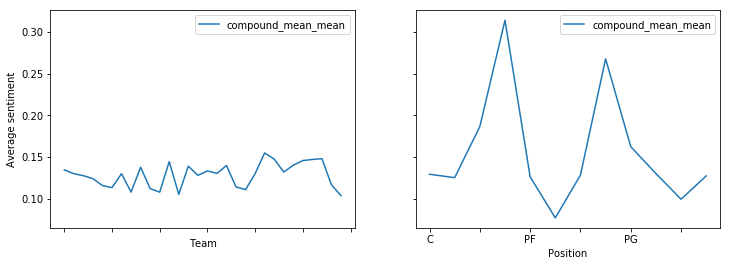

In [85]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Tm').mean().reset_index().plot('Tm', 'compound_mean_mean', ax = ax1);
ax1.set_xlabel('Team')
ax1.set_ylabel('Average sentiment')
join_df.groupby('Pos_y').mean().reset_index().plot('Pos_y', 'compound_mean_mean', ax = ax2);
ax2.set_xlabel('Position')
ax2.set_xticklabels(['', 'C','', 'PF','', 'PG','', 'SF','', 'SG']);

In [86]:
join_df.groupby('Tm').mean().sort_values('compound_mean_mean').head(2)

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
Tm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WAS,2014.957746,0.103589,0.413372,158.478873,2009.859155,2017.309859,79.281690,221.253521,282.211268,27.366197,58.718310,1354.746479,12.836620,0.524629,0.271071,0.257143,5.005634,16.288732,10.726761,12.909859,1.580282,1.384507,13.04000,18.683099,1.471831,1.528169,2.991549,0.082845,-1.557746,-0.292958,-1.847887,0.729577,3.30000,7.212676,0.444800,0.695775,1.940845,0.301508,2.594366,5.273239,0.476814,0.490671,1.384507,1.857746,0.738257,0.864789,2.770423,3.629577,2.009859,0.691549,0.356338,1.187324,1.869014,8.670423,2015.957746,44.591549,6011752.0,55.1,25.4,0.3622,6.253025e+06,46.586382,6.098592
LAC,2014.972973,0.105155,0.426430,295.040541,2008.932432,2017.432432,78.743243,220.270270,265.608108,28.743243,57.527027,1315.418919,13.921622,0.541405,0.325595,0.293000,4.266216,15.132432,9.805405,12.748649,1.816216,1.683784,12.72027,19.281081,2.085135,1.443243,3.531081,0.095500,-0.664865,0.044595,-0.620270,1.063514,3.37973,7.302703,0.455324,0.848649,2.360811,0.320373,2.528378,4.947297,0.495311,0.511811,1.650000,2.235135,0.734890,0.798649,2.866216,3.658108,2.048649,0.722973,0.395946,1.150000,1.820270,9.244595,2015.972973,50.229730,13189366.0,55.0,6.7,0.4802,6.957210e+06,45.457688,7.040541


#### Create modeling dataframe

In [27]:
# drop non-players
join_df = join_df.dropna(subset = ['TOVP'])

In [29]:
join_df['youth'] = (join_df['Age'].mean() - join_df['Age']).clip(0)
join_df['oldness'] = (join_df['Age'] - join_df['Age'].mean()).clip(0)
join_df['rookie'] = join_df['experience'] <=1

In [30]:
join_df['ThreePP'] =join_df['ThreePP'].fillna(join_df['ThreePP'].mean())
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']

In [31]:
join_df['height_dummies'] = pd.cut(join_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])

In [32]:
join_df.to_csv('modeling_data/nba_player_model_data.tsv', sep='\t', index=False)
#join_df = pd.read_csv('modeling_data/nba_model_data.tsv', sep='\t')

In [96]:
fit_df = join_df.replace({'M':'B', 'L':'W'}).query('Race == "W" or Race == "B"').query('user_count > 20')#

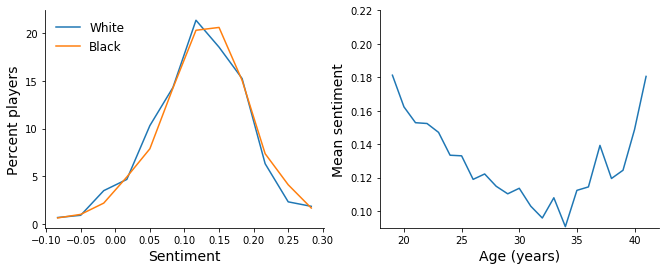

In [97]:
fs = 14
fig, (ax2, ax1) = plt.subplots(1,2, figsize = [11, 4])
fit_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
#join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean', ax = ax2);
#plt.errorbar(['Black', 'White'], race_means, race_stds)
bin_width = 0.03333
sentiment_bins = np.arange(-0.1, 0.3, bin_width)
white_hist, _ = np.histogram(fit_df.query('Race == "W"')['compound_mean_mean'], bins = sentiment_bins)
black_hist, _ = np.histogram(fit_df.query('Race == "B"')['compound_mean_mean'], bins = sentiment_bins)
ax2.plot(sentiment_bins[:-1] + bin_width /2,100* white_hist / white_hist.sum() , label='White')
ax2.plot(sentiment_bins[:-1] + bin_width /2,100* black_hist / black_hist.sum() , label='Black')
ax1.set_ylabel('Mean sentiment', fontsize = fs)
ax1.set_xlabel('Age (years)', fontsize = fs)
ax2.set_xlabel('Sentiment', fontsize = fs)
ax2.set_ylabel('Percent players', fontsize = fs)
ax1.set_ylim([0.09, 0.22]);
ax2.legend(fontsize = fs-2, frameon=False, loc='upper left')
ax1.legend().remove()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.savefig('Sentiment hist age.png',bbox_inches='tight', dpi=600)

In [107]:
from scipy.stats import ttest_ind
ttest_ind(fit_df.query('Race == "B"')['compound_mean_mean'],
          fit_df.query('Race == "W"')['compound_mean_mean'])

Ttest_indResult(statistic=1.7891814429804187, pvalue=0.07375229360758082)

## Regression models
### Salary

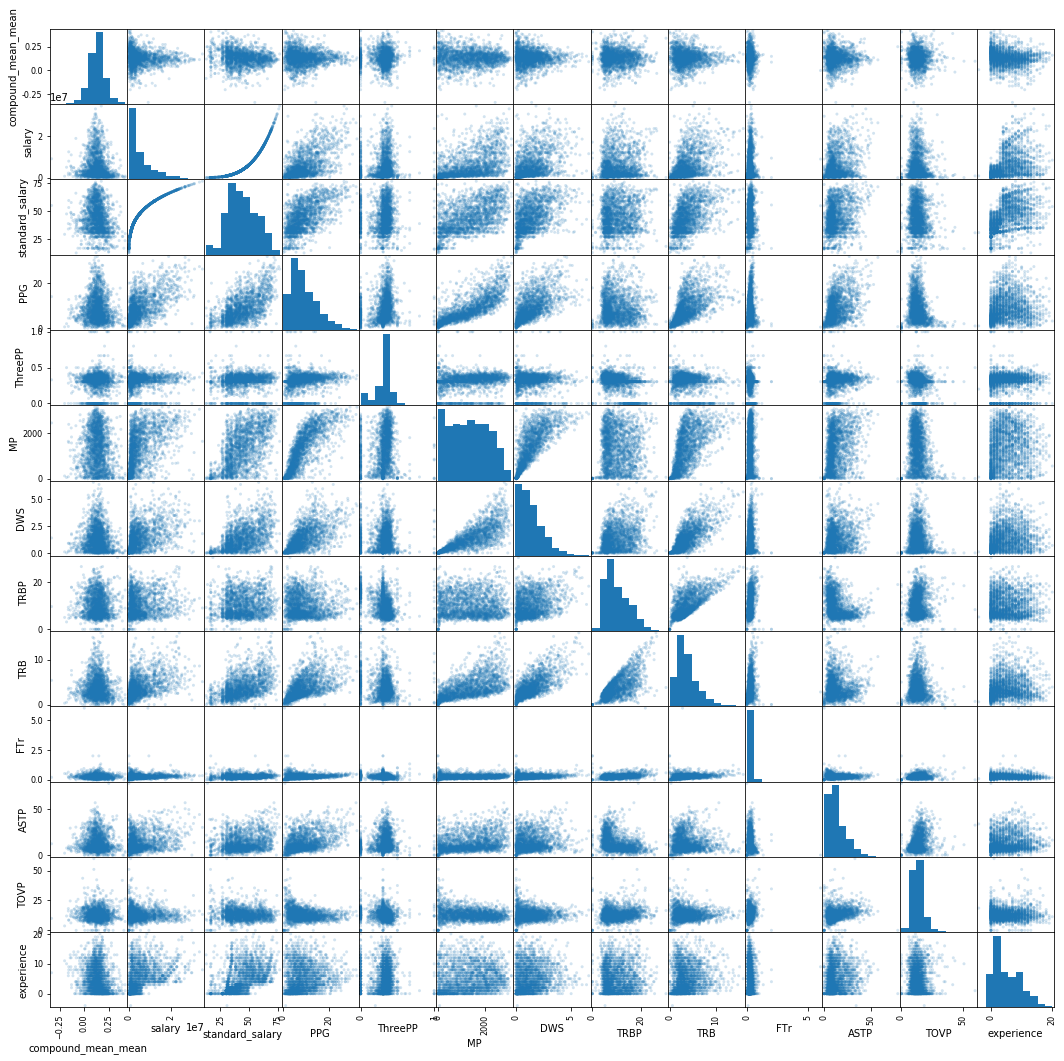

In [135]:
from pandas.plotting import scatter_matrix
scatter_matrix(join_df[['compound_mean_mean', 'salary', 'standard_salary', 'PPG',
                        'ThreePP', 'MP', 'DWS', 'TRBP', 'TRB', 'FTr', 'ASTP', 'TOVP', 'experience']], alpha=0.2, figsize=(18, 18));

In [98]:
salary_model = smf.wls( formula = 'standard_salary ~ rookie + MP + PPG + ThreePP + DWS + TRBP * height_dummies + AST + BLKP * height_dummies + STLP + TOVP',
                data = fit_df,
               weights = fit_df['G'],
#                missing='raise'   
               ).fit()

In [99]:
salary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        standard_salary   R-squared:                       0.473
Model:                            WLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     97.47
Date:                Sun, 27 Jan 2019   Prob (F-statistic):          1.06e-227
Time:                        17:49:07   Log-Likelihood:                -6344.4
No. Observations:                1752   AIC:                         1.272e+04
Df Residuals:                    1735   BIC:                         1.282e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        12.6306      4.901      2.577      0.010       3.018      22.243
rookie[T.True]                   -9.3176      0.524    -17.784      0.000     -10.345      -8.290
height_dummies[T.medium]         25.7113      4.735      5.430      0.000      16.424      34.998
height_dummies[T.tall]           26.7466      4.744      5.638      0.000      17.442      36.052
MP                                0.0009      0.001      1.525      0.128      -0.000       0.002
PPG                               0.6934      0.068     10.188      0.000       0.560       0.827
ThreePP                          -1.5608      1.881     -0.830      0.407      -5.249       2.127
DWS                               0.5700      0.338      1.685      0.092      -0.094       1.234
TRBP                              4.2126      0.848      4.965      0.000       2.549       5.877
TRBP:height_dummies[T.medium]    -4.3826      0.859     -5.104      0.000      -6.067      -2.699
TRBP:height_dummies[T.tall]      -4.0081      0.854     -4.694      0.000      -5.683      -2.333
AST                               0.9866      0.202      4.881      0.000       0.590       1.383
BLKP                             -5.6112      4.160     -1.349      0.178     -13.770       2.548
BLKP:height_dummies[T.medium]     6.6125      4.185      1.580      0.114      -1.596      14.821
BLKP:height_dummies[T.tall]       5.1158      4.162      1.229      0.219      -3.047      13.279
STLP                             -1.8982      0.400     -4.745      0.000      -2.683      -1.114
TOVP                              0.0702      0.070      1.010      0.313      -0.066       0.207
==============================================================================
Omnibus:                       10.137   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.219
Skew:                          -0.176   Prob(JB):                      0.00604
Kurtosis:                       2.876   Cond. No.                     7.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Calculate residual salary

In [100]:
fit_df['pred_std_salary'] = salary_model.predict(fit_df)
fit_df['std_salary_resid'] = fit_df['pred_std_salary']- fit_df['standard_salary']
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
2101,justin patton,2017,38.718985,7.247481,4.0,2.0,1.0
1353,gordon hayward,2017,73.839893,42.997639,5.0,2.0,1.0
2465,luol deng,2017,64.390081,36.602357,13.0,2.0,1.0
1848,joakim noah,2017,64.921912,39.640819,40.0,1.7,7.0
538,chandler parsons,2016,68.577291,44.718629,675.0,6.2,34.0


There is a big problem using rate states where low sample size is causing funky predicted salary. I think the best way to handle this would be to shrink the salary residuals based on # of games played, but I'm not 100% sure how to do that. So I will set the salary residual for all players with < 20 games to be 0.

In [101]:
fit_df.loc[ fit_df['G'] <20, 'std_salary_resid'] = 0
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
538,chandler parsons,2016,68.577291,44.718629,675.0,6.2,34.0
539,chandler parsons,2017,69.336099,46.102999,691.0,7.9,36.0
2989,paul millsap,2017,74.478198,51.894333,1143.0,14.6,38.0
1451,ian mahinmi,2016,63.245553,41.535583,555.0,5.6,31.0
1319,gerald wallace,2014,56.382362,35.826120,286.0,1.1,32.0


Most underpaid players

In [102]:
fit_df.sort_values('std_salary_resid', ascending=False).head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
2873,nikola jokic,2017,34.828226,61.800193,2443.0,18.5,75.0
535,chandler parsons,2013,31.024969,57.169517,2783.0,16.6,74.0
2649,michael beasley,2015,23.529724,48.843272,363.0,12.8,20.0
2699,mike james,2017,20.148403,45.256275,687.0,9.3,36.0
1537,jakarr sampson,2017,16.671498,40.699259,344.0,4.7,22.0


Some player salaries didn't get joined correctly due to name (e.g. Schroder vs Schroeder)

In [103]:
fit_df['std_salary_resid'] =fit_df['std_salary_resid'].fillna(fit_df['std_salary_resid'].mean())

### Sentiment regression models
First, a regression model for sentiment with features for performance, age, team wins, race, and height.

In [104]:
model = smf.wls( formula = 'compound_mean_mean ~ MP + PPG + ThreePP + DWS + TRBP + FTr+ ASTP + BLKP + STLP + TOVP + ' \
                'youth + oldness + C(rookie) + C(height_dummies) + std_salary_resid + C(Race)*PPG', \
#                       ' PPG +  + total_population+  * white_black_diff + C(Race) * clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : fit_df['Player']})

In [105]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.111
Model:                            WLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     9.844
Date:                Sun, 27 Jan 2019   Prob (F-statistic):           2.66e-24
Time:                        17:49:28   Log-Likelihood:                 2355.7
No. Observations:                1817   AIC:                            -4673.
Df Residuals:                    1798   BIC:                            -4569.
Df Model:                          18                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.1262      0.014      9.097      0.000       0.099       0.153
C(rookie)[T.True]               0.0326      0.005      5.964      0.000       0.022       0.043
C(height_dummies)[T.medium]    -0.0096      0.009     -1.095      0.274      -0.027       0.008
C(height_dummies)[T.tall]      -0.0033      0.010     -0.337      0.736      -0.023       0.016
C(Race)[T.W]                   -0.0227      0.010     -2.289      0.022      -0.042      -0.003
MP                          -4.709e-06   3.92e-06     -1.203      0.229   -1.24e-05    2.97e-06
PPG                             0.0004      0.000      0.896      0.370      -0.001       0.001
C(Race)[T.W]:PPG                0.0019      0.001      2.161      0.031       0.000       0.004
ThreePP                         0.0284      0.016      1.787      0.074      -0.003       0.060
DWS                             0.0019      0.003      0.680      0.497      -0.003       0.007
TRBP                           -0.0010      0.001     -1.595      0.111      -0.002       0.000
FTr                            -0.0058      0.009     -0.644      0.520      -0.024       0.012
ASTP                           -0.0002      0.000     -0.752      0.452      -0.001       0.000
BLKP                            0.0019      0.001      1.392      0.164      -0.001       0.005
STLP                            0.0030      0.003      1.085      0.278      -0.002       0.008
TOVP                           -0.0008      0.000     -1.791      0.073      -0.002    7.38e-05
youth                           0.0038      0.001      3.132      0.002       0.001       0.006
oldness                         0.0005      0.001      0.483      0.629      -0.001       0.002
std_salary_resid                0.0002      0.000      0.719      0.472      -0.000       0.001
==============================================================================
Omnibus:                       72.441   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.783
Skew:                          -0.395   Prob(JB):                     3.54e-22
Kurtosis:                       3.824   Cond. No.                     2.12e+04
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [307]:
predicted_senti = model.predict(fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']])

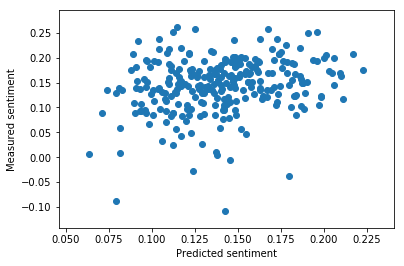

In [308]:
plt.scatter(predicted_senti, fit_df['compound_mean_mean'])
plt.xlabel('Predicted sentiment')
plt.ylabel('Measured sentiment');

## Coaches

In [108]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_race.tsv', sep='\t')
coaches_df['Tm'] = coaches_df['Tm'].replace({'CHA':'CHO'})

In [109]:
team_win_df = coaches_df.groupby(['Tm', 'season']).sum()['W'].reset_index()
team_win_df['season_WinP_prev'] = team_win_df['W'] / 82

In [110]:
coach_tenure = coaches_df.groupby(['Tm', 'Coach']).apply(lambda df: df.rank())[['season']].rename(columns={'season':'tenure'})
coaches_df = coaches_df.join(coach_tenure)
coaches_df['rookie'] = coaches_df['tenure'] == 1

In [111]:
coaches_df['prev_season'] = coaches_df['season']-1
coaches_df = coaches_df.merge(team_win_df.rename(columns = {'season': 'prev_season'}),
                              on = ['prev_season', 'Tm'], how='left', suffixes = ('', '_prev') )
coaches_df['winP_change'] = (coaches_df['season_WinP'] - coaches_df['season_WinP_prev']).fillna(0)

In [112]:
coaches_covariates_df = (coaches_df.merge(coaches_race_df, on = 'Coach')
                                   .rename(columns = {'Coach':'fuzzy_name'})
                                   .merge(player_sentiment_df, on = ['fuzzy_name', 'season'], how='inner')
                                   )

### Most and least popular coaches

In [113]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).query('user_count > 40').head(5)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
127,2014,38.0,NBA,BOS,82,40.0,42.0,0.488,0.540,brad stevens,2.0,False,2013,25.0,0.304878,0.183122,W,0.308052,0.374051,218
35,2013,52.0,NBA,CHO,82,43.0,39.0,0.524,0.476,steve clifford,1.0,True,2012,21.0,0.256098,0.267902,W,0.306171,0.406278,43
61,2013,50.0,NBA,PHO,82,48.0,34.0,0.585,0.427,jeff hornacek,1.0,True,2012,25.0,0.304878,0.280122,W,0.300402,0.391528,80
24,2013,54.0,NBA,DAL,82,49.0,33.0,0.598,0.552,rick carlisle,6.0,False,2012,41.0,0.500000,0.098000,W,0.271919,0.389770,149
122,2014,44.0,NBA,MIA,82,37.0,45.0,0.451,0.599,erik spoelstra,7.0,False,2013,54.0,0.658537,-0.207537,W,0.258637,0.416083,77


In [114]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).query('user_count > 40').tail(5)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
98,2015,52.0,NBA,MIN,82,29.0,53.0,0.354,0.433,sam mitchell,1.0,True,2014,16.0,0.195122,0.158878,B,-0.060409,0.427192,138
39,2017,56.0,NBA,CHO,82,36.0,46.0,0.439,0.476,steve clifford,5.0,False,2016,36.0,0.439024,-0.000024,W,-0.060783,0.411995,141
157,2013,42.0,NBA,NOP,82,34.0,48.0,0.415,0.439,monty williams,1.0,True,2012,NaN,NaN,0.000000,B,-0.063885,0.415914,48
57,2016,44.0,NBA,CHI,82,41.0,41.0,0.500,0.440,fred hoiberg,2.0,False,2015,42.0,0.512195,-0.012195,W,-0.070902,0.453887,221
156,2017,38.0,NBA,PHO,3,0.0,3.0,0.000,0.280,earl watson,3.0,False,2016,24.0,0.292683,-0.292683,B,-0.108258,0.452328,53


### Filter to coaches with enough games and comments and explore data

In [6]:
coaches_covariates_df.sample(2)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
69,2014,40.0,NBA,MEM,82,55.0,27.0,0.671,0.504,dave joerger,2.0,False,2013,50.0,0.609756,0.061244,W,0.231537,0.390565,94
51,2016,42.0,NBA,MEM,82,43.0,39.0,0.524,0.474,david fizdale,1.0,True,2015,42.0,0.512195,0.011805,B,0.085435,0.440811,93


In [47]:
#coaches_covariates_df.to_csv('modeling_data/nba_coaches_covariates.tsv', sep='\t', index=False)
coaches_covariates_df = pd.read_csv('modeling_data/nba_coaches_covariates.tsv', sep='\t')
overunder_df = pd.read_csv('modeling_data/overunder.tsv', sep='\t', header=None, names=['Tm', 'over_under', 'season'])
coach_player_df = pd.read_csv('modeling_data/nba_coaches_player.tsv', sep='\t')

In [113]:
coaches_fit_df = (coaches_covariates_df.query('G >= 10 and user_count > 10')
                                       .merge(overunder_df, on=['Tm', 'season'])
                                       .merge(coach_player_df, on=['fuzzy_name']))
coaches_fit_df['age'] = coaches_fit_df['age'].fillna(coaches_fit_df['age'].mean())
coaches_fit_df['pro_player'] = coaches_fit_df['pro_seasons']>0

coaches_fit_df['over_underP'] = coaches_fit_df['over_under'] / 82
coaches_fit_df['delta_overP'] = coaches_fit_df['season_WinP'] - coaches_fit_df['over_underP']
coaches_fit_df['demean_winP'] = coaches_fit_df['season_WinP'] - coaches_fit_df['season_WinP'].mean()

In [112]:
print(coaches_fit_df['compound_mean_mean'].std())
print(coaches_fit_df.query('user_count > 100')['compound_mean_mean'].std())

0.09027282415898095
0.08107867348361394


In [140]:
coaches_fit_df.sort_values('delta_overP', ascending=False)[['fuzzy_name', 'Tm', 'season', 'compound_mean_mean', 'delta_overP']].head()

,fuzzy_name,Tm,season,compound_mean_mean,delta_overP
73,jeff hornacek,PHO,2013,0.300402,0.347195
26,mike budenholzer,ATL,2014,0.190283,0.238098
128,terry stotts,POR,2015,0.246040,0.213829
89,jason kidd,MIL,2014,0.153531,0.201220
84,steve kerr,GSW,2014,0.236338,0.201146


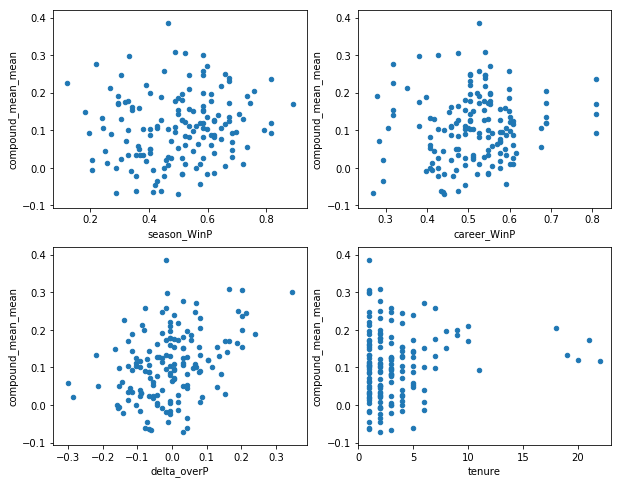

In [99]:
fig, axes = plt.subplots(2,2, figsize = [10, 8])
coaches_fit_df.plot.scatter('season_WinP', 'compound_mean_mean', ax = axes[0,0]);
coaches_fit_df.plot.scatter('career_WinP', 'compound_mean_mean', ax = axes[0,1]);
coaches_fit_df.plot.scatter('delta_overP', 'compound_mean_mean', ax = axes[1,0]);
coaches_fit_df.plot.scatter('tenure', 'compound_mean_mean', ax = axes[1,1]);

In [18]:
coaches_fit_df.groupby('race').agg(['mean', 'count'])[['compound_mean_mean', 'tenure', 'season_WinP', 'age', 'pro_player']]

compound_mean_mean          tenure       season_WinP              age  \
                   mean count      mean count        mean count       mean   
race                                                                         
B              0.060417    47  2.361702    47    0.467489    47  49.297872   
W              0.128414   102  4.029412   102    0.515186   102  51.784314   

           pro_player        
     count       mean count  
race                         
B       47   0.723404    47  
W      102   0.392157   102

#### Coaches model - no clustering

In [100]:
coach_model = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie  + pro_player' \
                                  ' + career_WinP + winP_change +season_WinP + C(race) * delta_overP',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [101]:
coach_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.402
Model:                            WLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     9.605
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           3.92e-12
Time:                        08:03:50   Log-Likelihood:                 190.72
No. Observations:                 154   AIC:                            -359.4
Df Residuals:                     143   BIC:                            -326.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1819      0.048      3.826      0.000       0.088       0.276
rookie[T.True]               0.0315      0.015      2.130      0.035       0.002       0.061
pro_player[T.True]          -0.0163      0.012     -1.341      0.182      -0.040       0.008
C(race)[T.W]                 0.0471      0.013      3.638      0.000       0.022       0.073
age                         -0.0033      0.001     -4.065      0.000      -0.005      -0.002
tenure                       0.0048      0.002      2.451      0.015       0.001       0.009
career_WinP                  0.1704      0.083      2.061      0.041       0.007       0.334
winP_change                 -0.1175      0.070     -1.685      0.094      -0.255       0.020
season_WinP                 -0.0833      0.066     -1.267      0.207      -0.213       0.047
delta_overP                  0.3852      0.123      3.133      0.002       0.142       0.628
C(race)[T.W]:delta_overP     0.0774      0.122      0.632      0.528      -0.165       0.319
==============================================================================
Omnibus:                        1.184   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.553   Jarque-Bera (JB):                1.037
Skew:                          -0.201   Prob(JB):                        0.595
Kurtosis:                       3.000   Cond. No.                     1.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Coaches model - full - with clustered errors

In [114]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change + demean_winP + delta_overP * C(race) + pro_player',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [115]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.402
Model:                            WLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     11.42
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           3.41e-10
Time:                        08:20:26   Log-Likelihood:                 190.72
No. Observations:                 154   AIC:                            -359.4
Df Residuals:                     143   BIC:                            -326.0
Df Model:                          10                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1403      0.077      1.829      0.067      -0.010       0.291
rookie[T.True]               0.0315      0.014      2.299      0.021       0.005       0.058
C(race)[T.W]                 0.0471      0.017      2.825      0.005       0.014       0.080
pro_player[T.True]          -0.0163      0.019     -0.854      0.393      -0.054       0.021
age                         -0.0033      0.001     -2.650      0.008      -0.006      -0.001
tenure                       0.0048      0.002      2.160      0.031       0.000       0.009
career_WinP                  0.1704      0.072      2.353      0.019       0.028       0.312
winP_change                 -0.1175      0.068     -1.721      0.085      -0.251       0.016
demean_winP                 -0.0833      0.056     -1.482      0.138      -0.194       0.027
delta_overP                  0.3852      0.085      4.542      0.000       0.219       0.551
delta_overP:C(race)[T.W]     0.0774      0.092      0.844      0.399      -0.102       0.257
==============================================================================
Omnibus:                        1.184   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.553   Jarque-Bera (JB):                1.037
Skew:                          -0.201   Prob(JB):                        0.595
Kurtosis:                       3.000   Cond. No.                     1.53e+03
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
0.39 / 82

0.00475609756097561

#### Coaches model - performance only - with clustered errors

In [116]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ career_WinP + winP_change +demean_winP + delta_overP',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [117]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.220
Model:                            WLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     19.72
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           4.71e-10
Time:                        08:21:21   Log-Likelihood:                 170.30
No. Observations:                 154   AIC:                            -330.6
Df Residuals:                     149   BIC:                            -315.4
Df Model:                           4                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0100      0.044     -0.225      0.822      -0.097       0.077
career_WinP     0.2290      0.076      3.008      0.003       0.080       0.378
winP_change    -0.1338      0.069     -1.925      0.054      -0.270       0.002
demean_winP    -0.1423      0.064     -2.209      0.027      -0.268      -0.016
delta_overP     0.5107      0.076      6.757      0.000       0.363       0.659
==============================================================================
Omnibus:                        1.384   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.009
Skew:                           0.173   Prob(JB):                        0.604
Kurtosis:                       3.193   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches model - race and performance - with clustered errors

In [118]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ career_WinP + winP_change + demean_winP + delta_overP * C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [119]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.299
Model:                            WLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     13.52
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           2.69e-09
Time:                        08:22:07   Log-Likelihood:                 178.47
No. Observations:                 154   AIC:                            -342.9
Df Residuals:                     147   BIC:                            -321.7
Df Model:                           6                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0043      0.042     -0.103      0.918      -0.086       0.077
C(race)[T.W]                 0.0529      0.018      2.931      0.003       0.018       0.088
career_WinP                  0.1464      0.083      1.761      0.078      -0.017       0.309
winP_change                 -0.1322      0.065     -2.027      0.043      -0.260      -0.004
demean_winP                 -0.0885      0.063     -1.405      0.160      -0.212       0.035
delta_overP                  0.3344      0.086      3.909      0.000       0.167       0.502
delta_overP:C(race)[T.W]     0.1588      0.099      1.606      0.108      -0.035       0.353
==============================================================================
Omnibus:                        0.223   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.895   Jarque-Bera (JB):                0.040
Skew:                           0.004   Prob(JB):                        0.980
Kurtosis:                       3.078   Cond. No.                         37.5
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches model - tenure and performance - with clustered errors

In [126]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ career_WinP + winP_change + demean_winP + age + tenure + rookie + pro_player + delta_overP',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [127]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.346
Model:                            WLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     11.42
Date:                Sun, 24 Feb 2019   Prob (F-statistic):           2.64e-09
Time:                        08:36:34   Log-Likelihood:                 183.81
No. Observations:                 154   AIC:                            -349.6
Df Residuals:                     145   BIC:                            -322.3
Df Model:                           8                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1394      0.080      1.735      0.083      -0.018       0.297
rookie[T.True]         0.0310      0.015      2.078      0.038       0.002       0.060
pro_player[T.True]    -0.0257      0.021     -1.245      0.213      -0.066       0.015
career_WinP            0.2481      0.076      3.273      0.001       0.100       0.397
winP_change           -0.1090      0.072     -1.523      0.128      -0.249       0.031
demean_winP           -0.1304      0.067     -1.944      0.052      -0.262       0.001
age                   -0.0034      0.001     -2.393      0.017      -0.006      -0.001
tenure                 0.0053      0.002      2.131      0.033       0.000       0.010
delta_overP            0.4837      0.073      6.621      0.000       0.341       0.627
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.327
Skew:                          -0.082   Prob(JB):                        0.849
Kurtosis:                       2.844   Cond. No.                         980.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

### Bootstrap to verify significance

In [132]:
from numpy.random import rand
def coach_sample(df, frac = 0.5):
    if rand() < frac:
        return df
    return None
coaches_fit_df.groupby('fuzzy_name').apply(coach_sample).dropna().shape

(80, 28)

In [133]:
%%time
race_coef = []
for _ in range(500):
    bootstrap_df = coaches_fit_df.groupby('fuzzy_name').apply(coach_sample).dropna()
    bootstrap_clustered = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change + demean_winP * C(race)',
                data = bootstrap_df,
               weights = 1 / (bootstrap_df['compound_mean_std'] / np.sqrt(bootstrap_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : bootstrap_df['fuzzy_name']})
    race_coef.append(bootstrap_clustered.params['C(race)[T.W]'])

Wall time: 1min 2s


Text(0,0.5,'# of times')

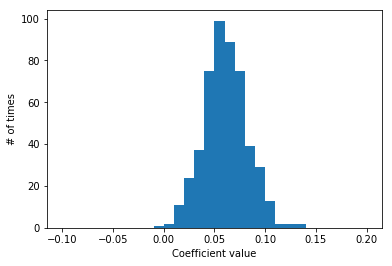

In [134]:
plt.hist(race_coef, bins = np.arange(-0.1, 0.2, 0.01));
plt.xlabel('Coefficient value')
plt.ylabel('# of times')

#### Coach plots for blog

In [135]:
import warnings
warnings.filterwarnings('ignore')

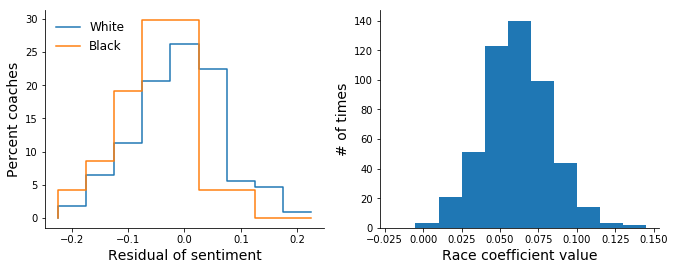

In [136]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [11, 4])
bin_width = 0.05
fs = 14
sentiment_bins = np.arange(-0.25, 0.3, bin_width)
coaches_fit_df['predicted_sentiment'] = coach_model_clustered.predict(coaches_fit_df)
coaches_fit_df['performance_model_residual'] = -coaches_fit_df['predicted_sentiment'] + coaches_fit_df['compound_mean_mean']
coaches_black_hist, _ = np.histogram(coaches_fit_df.query('race == "B"')['performance_model_residual'], sentiment_bins)
coaches_white_hist, _ = np.histogram(coaches_fit_df.query('race == "W"')['performance_model_residual'], sentiment_bins)
ax1.plot(sentiment_bins[:-1] + bin_width /2,100* coaches_white_hist / coaches_white_hist.sum(),
         label='White', drawstyle='steps')
ax1.plot(sentiment_bins[:-1] + bin_width /2,100* coaches_black_hist / coaches_black_hist.sum(),
         label='Black', drawstyle='steps')
ax1.set_ylabel('Percent coaches', fontsize = fs)
ax1.set_xlabel('Residual of sentiment', fontsize = fs)

ax2.hist(race_coef, bins = np.arange(-0.02, 0.15, 0.015));
ax2.set_xlabel('Race coefficient value', fontsize = fs)
ax2.set_ylabel('# of times', fontsize = fs)
ax1.legend(fontsize = fs-2, frameon=False, loc='upper left')
#ax1.legend().remove()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.savefig('Coach sentiment.png',bbox_inches='tight', dpi=600)